In [2]:
import matplotlib.pyplot as plt
import finoptions as fin
import scipy.stats as stats
import numpy as np
from joblib import Parallel, delayed

# TP 3

## Exercice 1

In [3]:
def poisson(l, T):
    n = np.random.poisson(l * T)
    t = np.sort(np.random.uniform(0, T, n))
    t = np.insert(t, 0, 0)
    N = np.arange(n + 1)
    return t, N

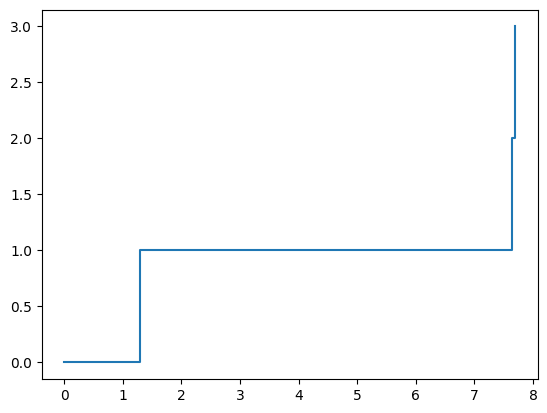

In [4]:
t, N = poisson(0.5, 10)
plt.step(t, N, where="post")
plt.show()

In [5]:
def poisson_binom(l, T, N, p):
    n = np.random.poisson(l * T)
    t = np.insert(np.sort(np.random.uniform(0, T, n)), 0, 0)
    jumps = np.random.binomial(N, p, size=n)
    process = np.insert(np.cumsum(jumps), 0, 0)

    return t, process

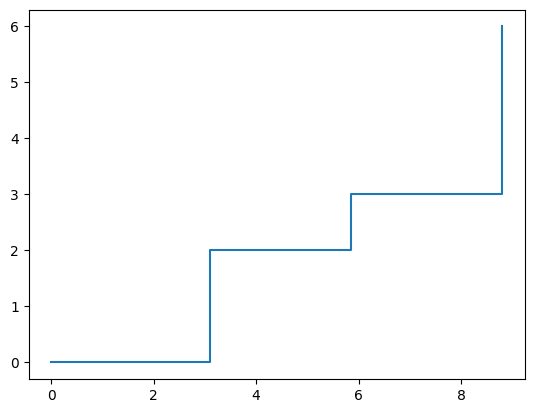

In [6]:
t, N = poisson_binom(0.5, 10, 5, 0.3)
plt.step(t, N, where='post')
plt.show()

In [7]:
def terminal(n, l, T, N, p):
    term = np.zeros(n)
    for i in range(n):
        term[i] = poisson_binom(l, T, N, p)[1][-1]
    return term

In [8]:
n = 100_000
q = stats.norm.ppf(0.995)

In [9]:
X_T = terminal(n, 2, 10, 5, 0.3)
f_S = X_T > 50
IC = np.mean(f_S) + q * np.array((-np.std(f_S)/np.sqrt(n), np.std(f_S)/np.sqrt(n)))
print(np.mean(f_S))
print(IC)

0.01058
[0.00974661 0.01141339]


## Exercice 2

$$ X_t = x + \mu t + \sigma B_t + \sum_{i = 1}^{N_t}Y_i Z_i $$
Avec $(N_t)_t$ un processus de poisson de paramètre $\lambda = \frac13$, $(Y_i)_i$ iid de loi $\frac12\delta_{-1} + \frac12\delta_{+1}$, et les $(Z_i)_i$ suivent une loi de poisson de paramètre $\lambda_Z = 4$.

Par la suite on prendra $x=100,~~\mu = 0.05,~~\sigma=0.2,~~T=5$.

In [10]:
def sauts(l=1/3, T=5):
    num_jumps = np.random.poisson(l * T)
    times = np.sort(np.random.uniform(0, T, num_jumps))
    return times

In [11]:
def compose_poisson(jump_times, l=1/3, l_Z=4, T=5):
    N_T = len(jump_times)

    Y = 2 * np.random.randint(0, 2, size=N_T) - 1
    Z = np.random.poisson(l_Z, size=N_T)

    times = np.insert(jump_times, 0, 0)
    process = np.insert(np.cumsum(Y * Z), 0, 0)

    return times, process

In [12]:
compose_poisson(sauts())

(array([0.        , 1.15654412, 3.32655308]), array([  0,  -6, -14]))

In [13]:
def traj(l=1/3, l_Z=4, T=5, x=100, mu=0.05, sigma=0.2, steps=100):
    jump_times = sauts(l, T)
    jumps = compose_poisson(jump_times, l, l_Z, T)[1]
    time_interval = np.concatenate(([0], jump_times, [T])) #est de la forme [0, T_1, T_2, ..., T_Final, T] avec T_i les temps de saut

    X = [x]
    times = [0]
    
    for i in range(len(time_interval) - 1):
        h = (time_interval[i + 1] - time_interval[i])/steps
        for j in range(steps):
            times.append(times[-1] + h)
            X.append(X[-1] + mu * h + sigma * np.random.normal(0, 1) * np.sqrt(h))
        X[-1] += jumps[i]
    return times, X

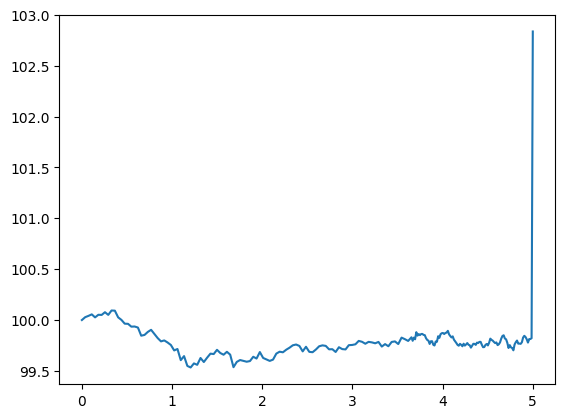

In [14]:
t, X = traj()
plt.plot(t, X)
plt.show()

In [15]:
def terminal_state(l=1/3, l_Z=4, T=5, x=100, mu=0.05, sigma=0.2, steps=100):
    return traj(l, l_Z, T, x, mu, sigma, steps)[1][-1]

In [16]:
def V_estim(n=100_000, l=1/3, l_Z=4, T=5, x=100, mu=0.05, sigma=0.2, steps=100, K=110, r=0.01):
    vals_X_T = np.array(Parallel(n_jobs=-1)(delayed(terminal_state)(l, l_Z, T, x, mu, sigma, steps)  for _ in range(n)))
    f_X = np.exp(-r * T) * np.maximum(K - vals_X_T, 0)

    V = np.mean(f_X)

    return V, V + 1.96 * np.array((-np.std(f_X)/np.sqrt(n), np.std(f_X)/np.sqrt(n)))

In [17]:
V, IC = V_estim()

In [18]:
print(V, IC)

10.56843234153391 [10.5115523  10.62531238]


In [19]:
S0 = 100
mu, mu_tilde = 0.07, 0.05
sigma, sigma_tilde = 0.3, 0.2
T = 10
l = 1
kappa = np.exp(mu_tilde) - 1

On a d'après le cours

\begin{equation*}
S_t = S_0\exp{\left(\left\{ \mu - \lambda\kappa -\frac{\sigma^2}2 \right\}t + \sigma B_t\right)}\Pi_{i=1}^{N_t}\tilde{Y}_i
\end{equation*}

Avec $N_t \sim \textit{Pois}(\lambda t)$, $B_t \sim \mathcal{N}(0,~t)$ et $\ln\tilde{Y}_i=\ln Y_{t_i}\sim \mathcal{N}(\tilde{\mu}+\frac12\tilde{\sigma}^2,~\tilde{\sigma}^2)$

In [37]:
def explicite(n):
    N_T = np.random.poisson(l * T, n)
    prod = np.zeros(n)
    for i in range(n):
        if N_T[i] > 0:
            Y = np.exp(np.random.normal(mu_tilde + 0.5 * sigma_tilde**2, sigma_tilde, N_T[i]))
            prod[i] = np.prod(Y)
        else:
            prod[i] = 1
    

    simul_T = S0 * np.exp( (mu - l * kappa - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.normal(0, 1, n) ) * prod

    N_mid = np.random.poisson(l * T/2, n)
    prod_mid = np.zeros(n)
    for i in range(n):
        if N_mid[i] > 0:
            Y = np.exp(np.random.normal(mu_tilde + 0.5 * sigma_tilde**2, sigma_tilde, N_mid[i]))
            prod_mid[i] = np.prod(Y)
        else:
            prod_mid[i] = 1
    simul_mid = S0 * np.exp( (mu - l * kappa - 0.5 * sigma**2) * T/2 + sigma * np.sqrt(T/2) * np.random.normal(0, 1, n) ) * prod_mid

    V = np.maximum(simul_mid, simul_T)

    return np.mean(V), np.mean(V) + stats.norm.ppf(0.995) * np.array((-np.std(V), np.std(V)))/np.sqrt(n)

In [45]:
n = 1_000_000
pay_off, IC_99 = explicite(n)

In [46]:
print(f"Estimation pour n = {n} simulations : {pay_off} \nIC au niveau 1% : {IC_99}.")

Estimation pour n = 1000000 simulations : 378.8493808225781 
IC au niveau 1% : [377.35483277 380.34392888].
